## Dependencias 

In [23]:
import numpy as np 
import pandas as pd 


import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from sklearn.tree import DecisionTreeClassifier,plot_tree,export_text
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score
#from scikitplot.metrics import plot_roc
from varclushi import VarClusHi

from functools import reduce

from CreditScoringToolkit.frequency_table import frequency_table

cf.go_offline()

## Cargar Datos

In [2]:
data = pd.read_sas('../data/churn.sas7bdat')
data.shape

(2801, 14)

In [3]:
data.head()

,V_ACCT_LGHT,C_IP,C_VMP,V_N_VM_MESS,V_T_DAY_CHG,V_T_EVE_CALLS,V_T_EVE_CHG,V_T_NIG_CALLS,V_T_NIG_CHG,V_T_INT_CALLS,V_T_INT_CHG,V_CS_CALLS,TARGET,ID
0,128.0,b'No',b'Yes',25.0,45.07,99.0,16.78,91.0,11.01,3.0,2.70,1.0,0.0,1.0
1,107.0,b'No',b'Yes',26.0,27.47,103.0,16.62,103.0,11.45,3.0,3.70,1.0,0.0,2.0
2,137.0,b'No',b'No',0.0,41.38,110.0,10.30,104.0,7.32,5.0,3.29,0.0,0.0,3.0
3,65.0,b'No',b'No',0.0,21.95,83.0,19.42,111.0,9.40,6.0,3.43,4.0,1.0,11.0
4,168.0,b'No',b'No',0.0,21.90,71.0,8.92,128.0,6.35,2.0,3.02,1.0,0.0,13.0


## Partición

In [4]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
train.shape, valid.shape

((1960, 14), (841, 14))

## Naturaleza de variables 

In [5]:
um = ['ID']
varc = [v for v in data.columns if v[:2]=='V_']
vard = [v for v in data.columns if v[:2]=='C_']
vart = ['TARGET']
len(varc),len(vard)

(10, 2)

## Análisis Exploratorio de Datos 

### Discreto

#### Frecuencia

In [6]:
frequency_table(train, vard)
frequency_table(train, vart)

****Frequency Table  C_IP  ***


        Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
C_IP                                                              
b'No'         1778    0.907143              1778          0.907143
b'Yes'         182    0.092857              1960          1.000000




****Frequency Table  C_VMP  ***


        Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
C_VMP                                                             
b'No'         1423     0.72602              1423           0.72602
b'Yes'         537     0.27398              1960           1.00000




****Frequency Table  TARGET  ***


        Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
TARGET                                                            
0.0           1677    0.855612              1677          0.855612
1.0            283    0.144388              1960          1.000000






### Continuo 

#### Ausentes 

In [7]:
train[varc].isna().sum()

V_ACCT_LGHT      0
V_N_VM_MESS      0
V_T_DAY_CHG      0
V_T_EVE_CALLS    0
V_T_EVE_CHG      0
V_T_NIG_CALLS    0
V_T_NIG_CHG      0
V_T_INT_CALLS    0
V_T_INT_CHG      0
V_CS_CALLS       0
dtype: int64

#### Multicolinealidad 

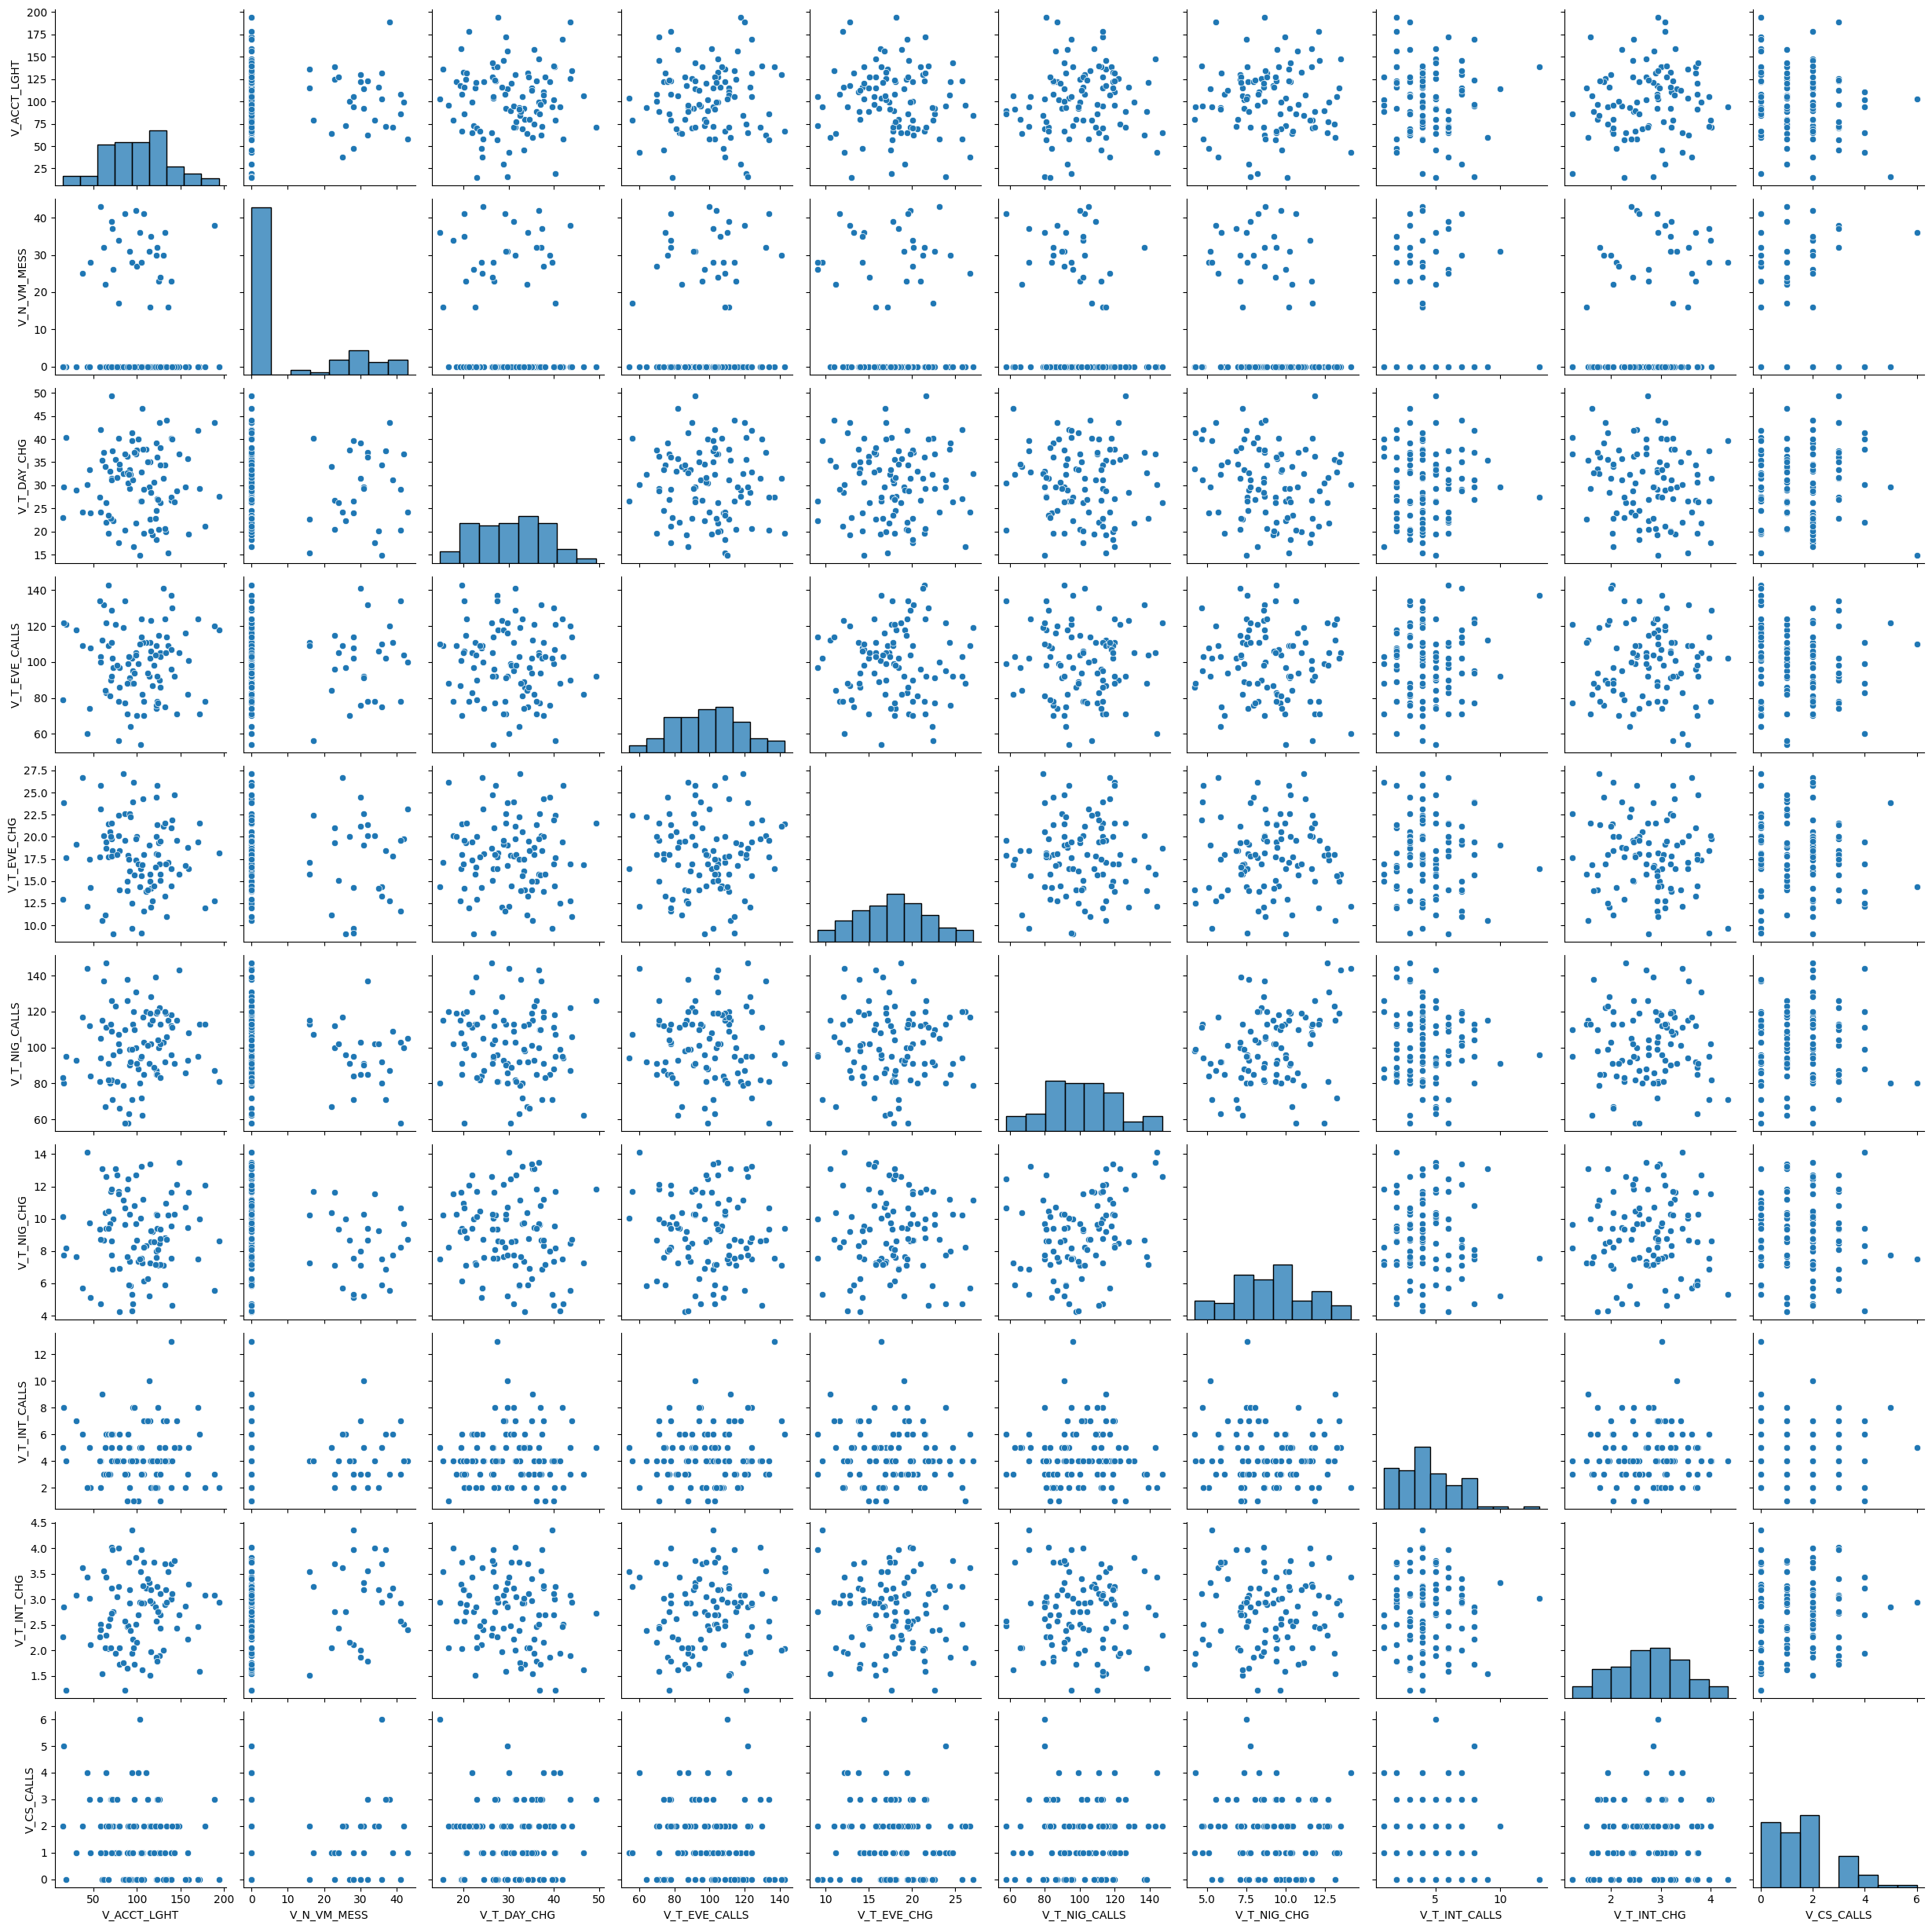

In [8]:
sns.pairplot(train[varc].sample(100))

In [9]:
vc = VarClusHi(df=train,feat_list=varc).varclus()

In [10]:
vc.rsquare

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,V_N_VM_MESS,0.146135,0.000391,0.854199
1,0,V_T_DAY_CHG,0.391998,0.000248,0.608153
2,0,V_T_EVE_CHG,0.310623,0.000009,0.689383
3,0,V_T_INT_CALLS,0.210493,0.000418,0.789837
4,1,V_T_NIG_CALLS,0.214360,0.000735,0.786217
5,1,V_T_NIG_CHG,0.400396,0.001081,0.600252
6,1,V_CS_CALLS,0.456541,0.000976,0.543989
7,2,V_ACCT_LGHT,0.527801,0.001081,0.472710
8,2,V_T_EVE_CALLS,0.527801,0.000133,0.472261
9,3,V_T_INT_CHG,1.000000,0.000287,0.000000


In [11]:
mc = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])

In [12]:
mc

['V_T_DAY_CHG', 'V_CS_CALLS', 'V_T_EVE_CALLS', 'V_T_INT_CHG']

#### Distribución 

array([[<Axes: title={'center': 'V_T_DAY_CHG'}>,
        <Axes: title={'center': 'V_CS_CALLS'}>],
       [<Axes: title={'center': 'V_T_EVE_CALLS'}>,
        <Axes: title={'center': 'V_T_INT_CHG'}>]], dtype=object)

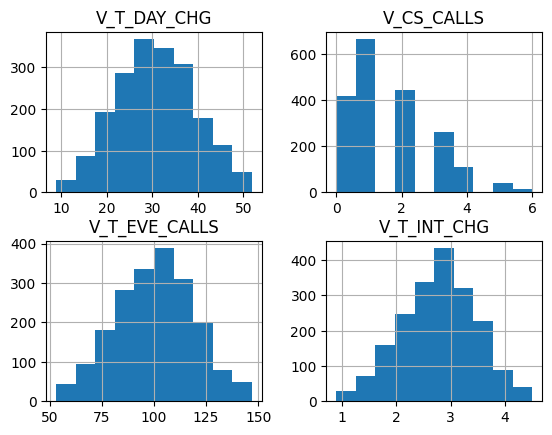

In [13]:
train[mc].hist()

#### Extremos 

In [14]:
for v,li,ls in train[mc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    train[f'ex_{v}'] = ((train[v]<li) | (train[v]>ls)).astype(int)
train['ex_'] = train.filter(like='ex_').max(axis=1) 
frequency_table(train, ['ex_'])

****Frequency Table  ex_  ***


     Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
ex_                                                            
0          1839    0.938265              1839          0.938265
1           121    0.061735              1960          1.000000






In [15]:
train = train[train['ex_']==0].reset_index(drop=True)
train.drop(train.filter(like='ex_').columns,axis=1,inplace=True)

array([[<Axes: title={'center': 'V_T_DAY_CHG'}>,
        <Axes: title={'center': 'V_CS_CALLS'}>],
       [<Axes: title={'center': 'V_T_EVE_CALLS'}>,
        <Axes: title={'center': 'V_T_INT_CHG'}>]], dtype=object)

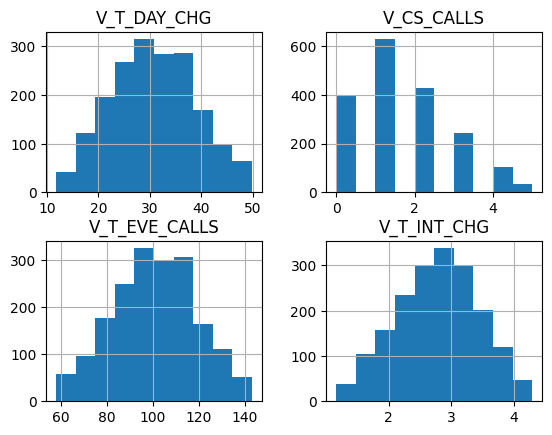

In [16]:
train[mc].hist()

## Pre-procesamiento

In [17]:
oh = OneHotEncoder(drop='if_binary',sparse_output=False)
oh.fit(train[vard])
train[oh.get_feature_names_out()] = oh.transform(train[vard])

In [18]:
varoh = oh.get_feature_names_out().tolist()

In [19]:
train = train[um+vart+varoh+mc]
train.head()

,ID,TARGET,C_IP_b'Yes',C_VMP_b'Yes',V_T_DAY_CHG,V_CS_CALLS,V_T_EVE_CALLS,V_T_INT_CHG
0,912.0,1.0,0.0,0.0,45.53,5.0,121.0,3.89
1,1478.0,0.0,0.0,0.0,28.66,1.0,117.0,2.65
2,1795.0,1.0,0.0,0.0,48.72,1.0,108.0,3.11
3,2286.0,0.0,0.0,0.0,26.59,1.0,98.0,3.19
4,2265.0,0.0,0.0,0.0,33.49,3.0,107.0,2.35


## Aprendizaje 

### Híper-Parametrización

In [20]:
dt = DecisionTreeClassifier()

#### Espacio híper-paramétrico

In [22]:
param_grid = {
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': np.arange(2,10),
    'min_samples_split': np.arange(0.05,0.1,0.01),
    'min_samples_leaf': np.arange(0.05,0.1,0.01),
    'max_features': ['sqrt', 'log2']+np.arange(2,10).tolist()
}

In [24]:
reduce(lambda x,y: x*y,[len(v) for v in param_grid.values()])

6000

#### Selección de híper parámetros 

##### Búsqueda Exhaustiva 

In [26]:
grid = GridSearchCV(estimator=dt,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    cv=5,
                    n_jobs=-1,
                    verbose=1,
                    )

In [27]:
grid.fit(train[varoh+mc],train[vart])

Fitting 5 folds for each of 6000 candidates, totalling 30000 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_features': ['sqrt', 'log2', 2, 3, 4, 5, 6, 7, 8,
                                          9],
                         'min_samples_leaf': array([0.05, 0.06, 0.07, 0.08, 0.09]),
                         'min_samples_split': array([0.05, 0.06, 0.07, 0.08, 0.09])},
             scoring='roc_auc', verbose=1)

In [28]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': np.int64(7),
 'max_features': 4,
 'min_samples_leaf': np.float64(0.05),
 'min_samples_split': np.float64(0.09000000000000001)}

In [29]:
grid.best_score_

np.float64(0.8427471574185953)

In [32]:
dt = grid.best_estimator_
dt

DecisionTreeClassifier(criterion='entropy', max_depth=np.int64(7),
                       max_features=4, min_samples_leaf=np.float64(0.05),
                       min_samples_split=np.float64(0.09000000000000001))

##### Búsqueda aleatoria

In [40]:
grid = RandomizedSearchCV(estimator=dt,
                    param_distributions=param_grid,
                    n_iter=60,
                    scoring='roc_auc',
                    cv=5,
                    n_jobs=-1,
                    verbose=1,
                    )

In [41]:
grid.fit(train[varoh+mc],train[vart])

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=np.int64(7),
                                                    max_features=4,
                                                    min_samples_leaf=np.float64(0.05),
                                                    min_samples_split=np.float64(0.09000000000000001)),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'max_features': ['sqrt', 'log2', 2, 3,
                                                         4, 5, 6, 7, 8, 9],
                                        'min_samples_leaf': array([0.05, 0.06, 0.07, 0.08, 0.09]),
                                        'min_samples_split': array([0.05, 0.06, 0.07, 0.08, 0.09])},
                   scoring='roc_auc', verbose=1)

In [42]:
grid.best_params_,grid.best_score_

({'min_samples_split': np.float64(0.060000000000000005),
  'min_samples_leaf': np.float64(0.05),
  'max_features': 5,
  'max_depth': np.int64(6),
  'criterion': 'entropy'},
 np.float64(0.8345816388896601))

In [43]:
dt = grid.best_estimator_

### Aprendizaje de parámetros 

In [44]:
dt.fit(train[varoh+mc],train[vart])

DecisionTreeClassifier(criterion='entropy', max_depth=np.int64(6),
                       max_features=5, min_samples_leaf=np.float64(0.05),
                       min_samples_split=np.float64(0.060000000000000005))

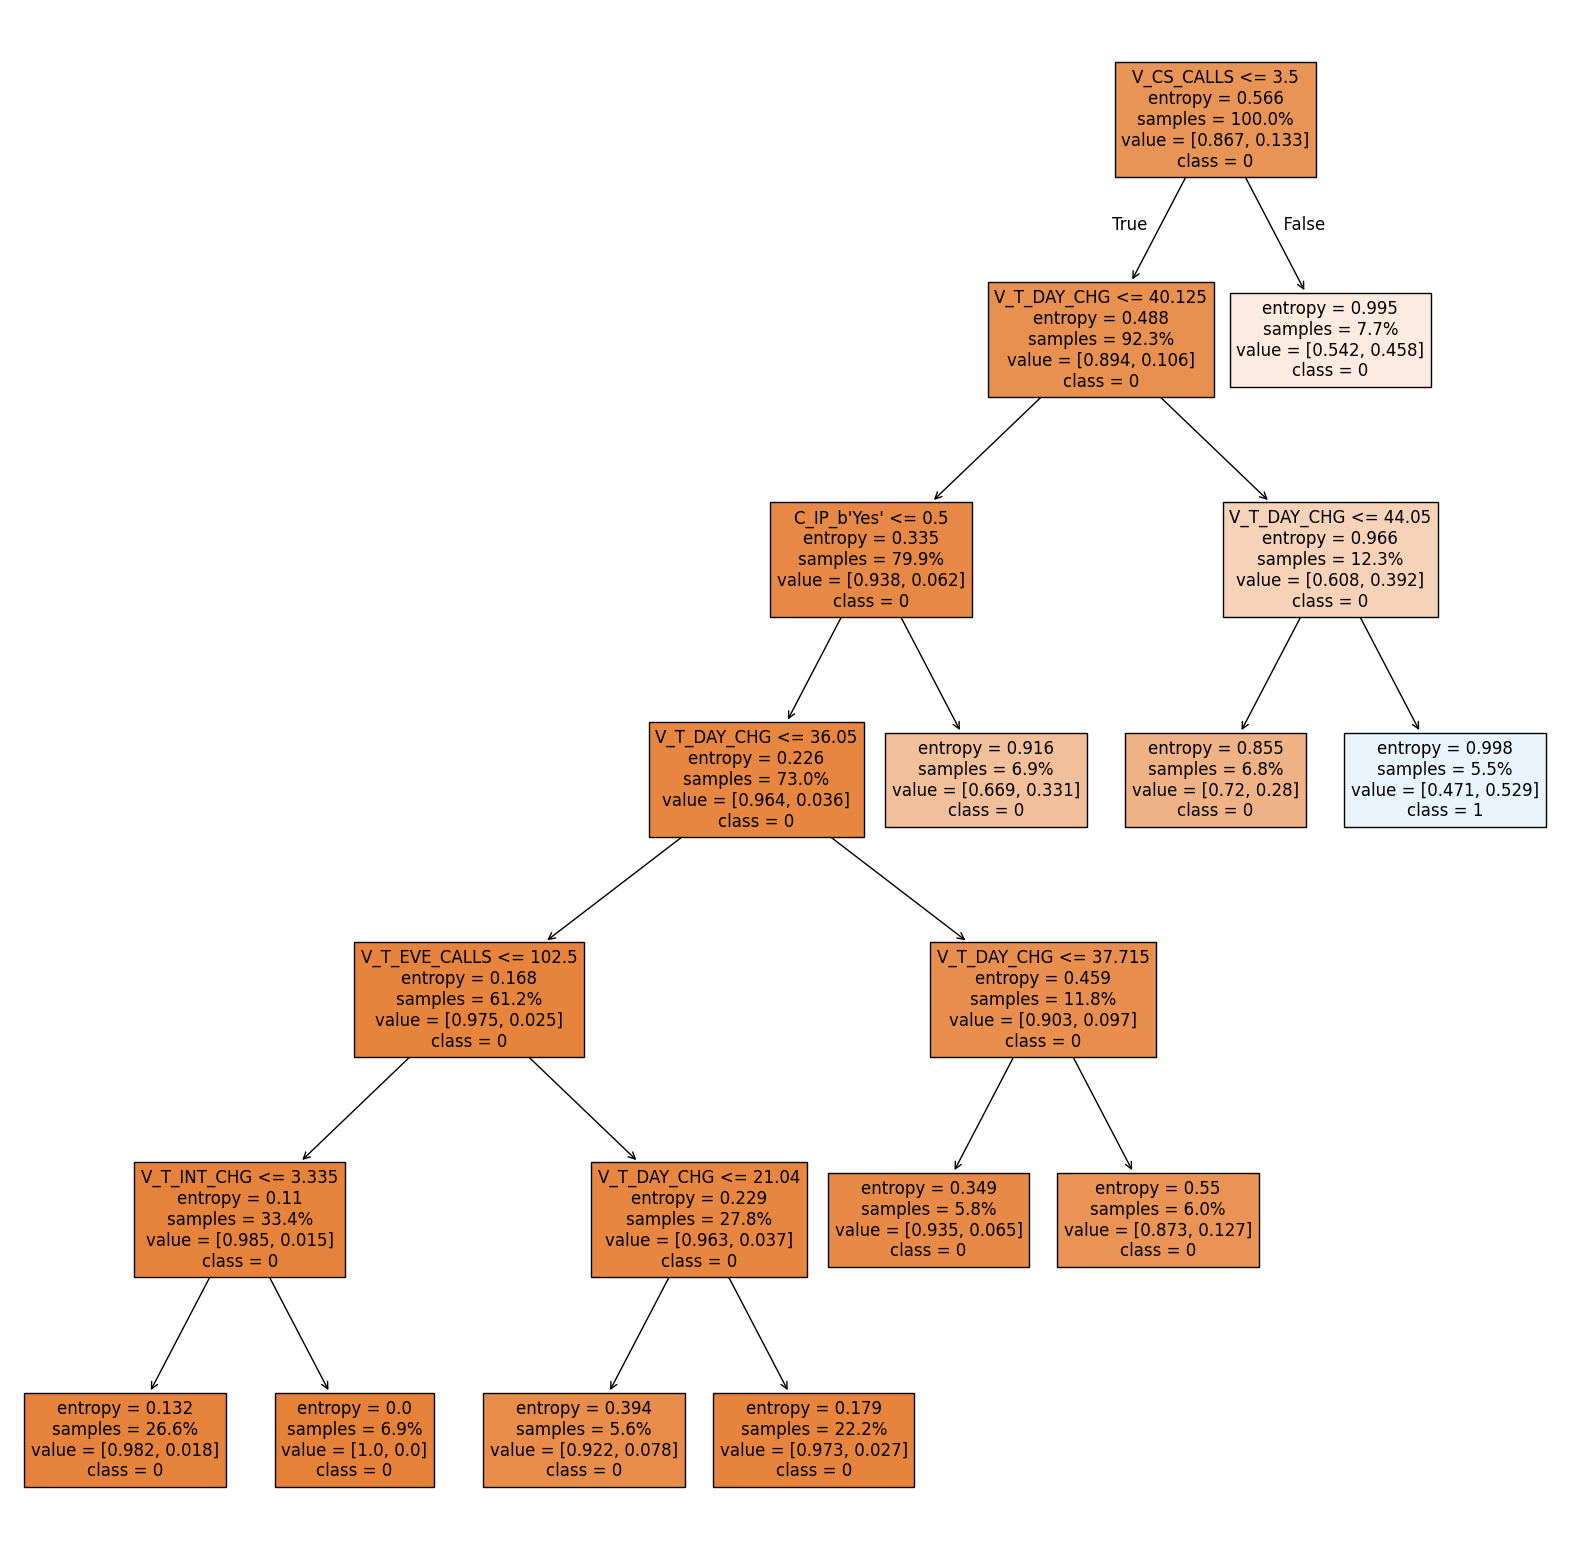

In [49]:
plt.figure(figsize=(20,20))
plot_tree(dt, feature_names=varoh + mc, class_names=['0', '1'], filled=True, proportion=True, label='all')
plt.show()

## Validación del modelo

In [46]:
valid[oh.get_feature_names_out()] = oh.transform(valid[vard])

In [47]:
print("train",roc_auc_score(y_true=train[vart],
              y_score=dt.predict_proba(train[varoh+mc])[:,1]))
print("valid",roc_auc_score(y_true=valid[vart],
                y_score=dt.predict_proba(valid[varoh+mc])[:,1]))

train 0.8596215399585179
valid 0.8556837248322148


## Uso del modelo 

In [48]:
train['node'] = dt.apply(train[varoh + mc])
train.head()

,ID,TARGET,C_IP_b'Yes',C_VMP_b'Yes',V_T_DAY_CHG,V_CS_CALLS,V_T_EVE_CALLS,V_T_INT_CHG,node
0,912.0,1.0,0.0,0.0,45.53,5.0,121.0,3.89,18
1,1478.0,0.0,0.0,0.0,28.66,1.0,117.0,2.65,10
2,1795.0,1.0,0.0,0.0,48.72,1.0,108.0,3.11,17
3,2286.0,0.0,0.0,0.0,26.59,1.0,98.0,3.19,6
4,2265.0,0.0,0.0,0.0,33.49,3.0,107.0,2.35,10


In [50]:
valid['node'] = dt.apply(valid[varoh + mc])

In [56]:
pd.concat([train[['node']+vart+um].groupby(['node']+vart).count().reset_index().assign(muestra='ent'),
valid[['node']+vart+um].groupby(['node']+vart).count().reset_index().assign(muestra='val')],ignore_index=True).to_clipboard(index=False)